In [33]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load the dataset
data = pd.read_csv('C:/Users/Lenovo/OneDrive/Desktop/k_CBIS-DDSM/csv.csv')


def load_and_preprocess_image(img_path, target_size=(224, 224)):
   
    base_path = 'C:/Users/Lenovo/OneDrive/Desktop/k_CBIS-DDSM'
    
    
    full_path = base_path + '/' + img_path
    
    img = cv2.imread(full_path)
    
    if img is None:
        raise ValueError(f"Image not found or unable to load: {full_path}")
    
    img = cv2.resize(img, target_size)
    img = img / 255.0  
    return img


images = []
labels = []
for index, row in data.iterrows():
    img_path = row['jpg_fullMammo_img_path']  
    breast_density = row['breast density'] - 1  
    
   
    img = load_and_preprocess_image(img_path)
    images.append(img)
    labels.append(breast_density)


X = np.array(images)
y = to_categorical(np.array(labels), num_classes=4)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

X_train = np.load('X_train.npy')
X_val = np.load('X_val.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')


model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[checkpoint])


model.save('breast_density_model.h5')


94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/10
20/20 [==============================] - 97s 5s/step - loss: 1.5757 - accuracy: 0.3000 - val_loss: 1.2690 - val_accuracy: 0.3856
Epoch 2/10
20/20 [==============================] - 87s 4s/step - loss: 1.3584 - accuracy: 0.3164 - val_loss: 1.2879 - val_accuracy: 0.3856
Epoch 3/10
20/20 [==============================] - 78s 4s/step - loss: 1.4526 - accuracy: 0.2754 - val_loss: 1.4515 - val_accuracy: 0.3856
Epoch 4/10
20/20 [==============================] - 76s 4s/step - loss: 1.4076 - accuracy: 0.3492 - val_loss: 1.5116 - val_accuracy: 0.3072
Epoch 5/10
20/20 [==============================] - 77s 4s/step - loss: 1.4208 - accuracy: 0.3033 - val_loss: 1.4318 - val_accuracy: 0.3399
Epoch 6/10
20/20 [==============================] - 83s 4s/step - loss: 1.3985 - accuracy: 0.2934 - val_loss: 1.3764 - val_accuracy: 0.2353
Epoch 7/10
20/20 [==============================] - 85s 4s/step - loss: 1.3904 - accuracy: 0.30

1/1 [==============================] - 0s 161ms/step


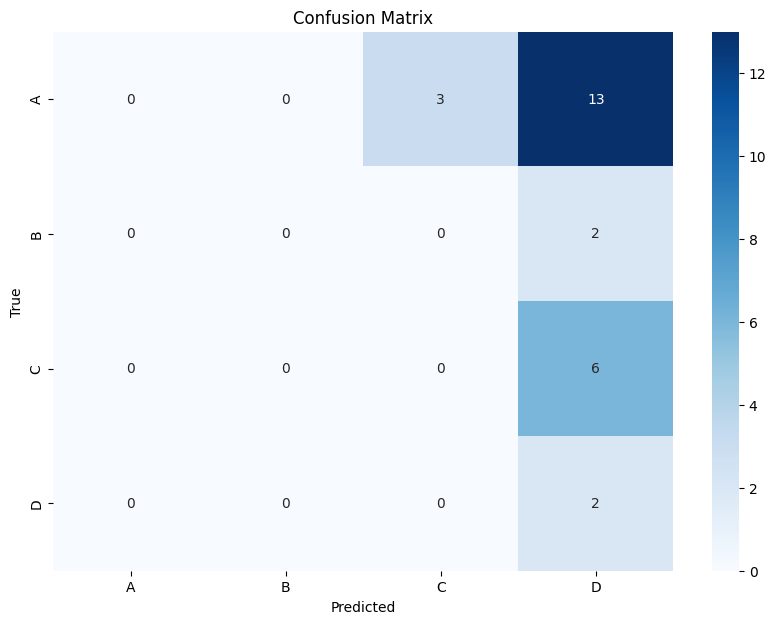

Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        16
           B       0.00      0.00      0.00         2
           C       0.00      0.00      0.00         6
           D       0.09      1.00      0.16         2

    accuracy                           0.08        26
   macro avg       0.02      0.25      0.04        26
weighted avg       0.01      0.08      0.01        26



C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [39]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


model = load_model('breast_density_model.h5')


test_data = pd.read_csv('C:/Users/Lenovo/OneDrive/Desktop/k_CBIS-DDSM/csv_test.csv')
img_paths = test_data['jpg_fullMammo_img_path']  
true_labels = test_data['breast density'] - 1  


def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  
    img = np.expand_dims(img, axis=0)  
    return img


predictions = []
true_labels_list = []


for img_file in img_paths:
    img_path = os.path.join('C:/Users/Lenovo/OneDrive/Desktop/k_CBIS-DDSM', img_file)
    img = preprocess_image(img_path)
    

    pred = model.predict(img)
    pred_label = np.argmax(pred)
    
   
    predictions.append(pred_label)
    true_labels_list.append(true_labels[img_paths.tolist().index(img_file)]) 


predictions = np.array(predictions)
true_labels_list = np.array(true_labels_list)


cm = confusion_matrix(true_labels_list, predictions)


plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'B', 'C', 'D'], yticklabels=['A', 'B', 'C', 'D'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(true_labels_list, predictions, target_names=['A', 'B', 'C', 'D']))